In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from astropy import constants as const

In [86]:
# Define star's properties

Mi = 2e33
Xi = 0.1
Yi = 0.86
Zi = 0.04


# constants
c = 2.99792458e10    # cm s^-1
a = 7.5646e-15     # erg cm^-3 K^-4
G = 6.67259e-8       # cm^3 g^-1 s^-2
N_A = 6.02214076e23    # mole^-1
k = 1.380658e-16    # cm^2 g s^-2 K^-1
R_sun = 6.96e10    # cm
sb = 5.67051e-5     # erg cm^-2 K^-4 s^-1

In [87]:
# Opacity table

dict={}
    
for n in range (126):   #126 tables
    name='Table'+str(n+1)
    skipr=245+(77*n)
    dict[name]=pd.read_csv('GN93hz', skiprows=skipr, nrows=70, delimiter='\\s+')
    
table23=dict['Table23']

In [88]:
table23 = table23.set_index('logT')

In [89]:
# Interpolation of opacity table

logR=(np.array(table23.columns)).astype(float)
logT=table23.index.values
kappa = table23.to_numpy()
interpolate_opacity=RegularGridInterpolator((logT,logR),kappa)

In [90]:
interpolate_opacity([8.2,-8.0])

array([-0.7935])

In [91]:
# Get opacity table for values of density and temperature

def get_logR(logrho, logT):
    T = 10**logT
    T6 = T * 1e-6
    rho = 10**logrho
    R = rho / T6**3
    logR = np.log10(R)
    return(logR)

In [92]:
# Calculate density

def cal_density(P, T):
    
    mu = (2*Xi+(3./4.)*Yi+(1./2.)*Zi)**(-1)
    rho = mu*((P-(1./3.)*a*T**4)/(N_A*k*T))
    if rho <= 0:
        rho = 1e-6

    return(rho)

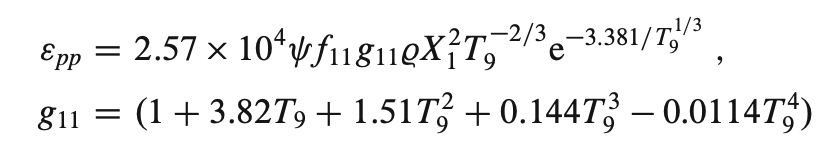

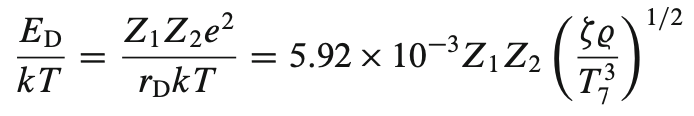

In [93]:
# Calculate energy density

psi = 1
zeta = 1
Z1=1
Z2=1
T = np.linspace(0.1,5,100)*1e7
rho = 1.41

T7 = T * 1e-7
T9 = T * 1e-9
f11 = np.exp(5.92e-3 * Z1*Z2 * (zeta * rho / T7**3)**(1/2.))
g11 = np.polyval([-0.0114,0.144,1.51,3.82,1],T9)
X1 = 1

eps_pp = 2.57e4 * psi * f11 * g11 * rho * X1**2 * T9**(-2/3) * np.exp(-3.381/T9**(1/3))

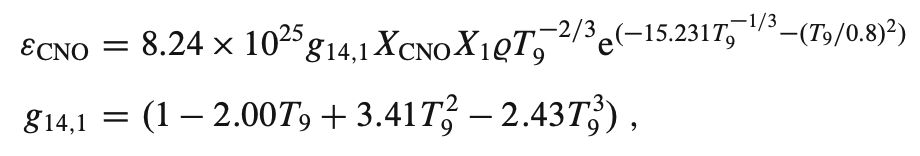

In [94]:
g141 = (1 - 2.00*T9 + 3.41*T9**2 - 2.43*T9**3)
X_cno = 1

eps_cno = 8.24e25 * g141 * X_cno * X1 * rho * T9**(-2/3) * np.exp(-15.231*T9**(-1/3) - (T9/0.8)**2)

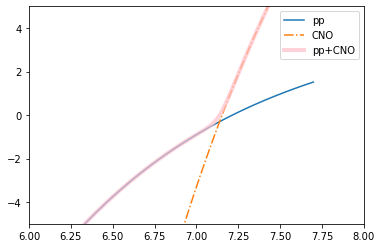

In [95]:
plt.figure()
plt.plot(np.log10(T), np.log10(eps_pp), label='pp',ls='-')
plt.plot(np.log10(T), np.log10(eps_cno), label='CNO',ls='-.')
plt.plot(np.log10(T),np.log10(eps_pp+eps_cno),label='pp+CNO',c='pink',ls='-',lw=4,alpha=0.7)
plt.xlim(6,8)
plt.ylim(-5,5)
plt.legend()
plt.show()

In [96]:
# Calculate density given P, T, and composition

def calc_den(m, l, P, T):
    
    rho = cal_density(P,T)
    opacity = interpolate_opacity
    
    del_rad = (3./(16.*np.pi*a*c*G))*(P*opacity*l/(m*T**4))
    gamma2 = 5./3.                                           # assumption
    del_ad = (gamma2-1)/gamma2
    
    if del_rad < del_ad:
        act_del = del_rad
        del_type = 'radiative'
    elif del_rad >= del_ad or pd.isna(del_rad):
        act_del = del_ad
        del_type = 'adiabatic'
        
    return(act_del,del_type)


In [97]:
# Set boundary conditions for the interior of the star

def interior(free):

    L_s, P_c, R_s, T_c = free
    
    rho_c = cal_density(P_c,T_c)
    
    eps_c, epss = (eps_pp+eps_cno, [eps_pp,eps_cno])
    
    m_0 = 1e-6          # away from 0
    l_c = eps_c*m_0
    del_c, del_type = calc_actual_del(m_0,l_c,P_c,T_c)
    
    opacity_c = get_opacity(rho_c,T_c)
    
    l = l_c
    P = P_c - ((3.*G/(8.*np.pi))*(4.*np.pi/3.*rho_c)**(4/3)*m_0**(2/3))
    r = ((3./(4.*np.pi*rho_c))*m_0)**(1/3)
    
    if del_type=='radiative':
        T = (T_c**4 - ((1./(2.*a*c))*(3./(4.*np.pi))**(2/3)*opacity_c*eps_c*rho_c**(4/3)*m_0**(2/3)))**(1/4)
    elif del_type=='adiabatic':
        T = np.exp(np.log(T_c) - ((np.pi/6.)**(1/3)*G*(del_c*rho_c**(4/3)/P_c)*m_0**(2/3)))
    
    return(l,P,r,T)


In [98]:
# Calculate Eddington pressure

def eddington_pressure(tau, P, free):
    
    L_s, P_c, R_s, T_c = free
    
    T_edd = ((3./4.)*(L_s/(4.*np.pi*R_s**2*sb))*(tau+(2./3.)))**(1/4)
    rho_s = calc_density(P, T_edd)
    opacity_grey = get_opacity(rho_s, T_edd)
    dPdtau = G*Mi/(R_s**2*opacity_grey)
    
    return(dPdtau)


In [99]:
# Set boundary conditions for the exterior of the star

def exterior(free):
    
    L_s, P_c, R_s, T_c = free
    
    rho_s = Mi/((4./3.)*np.pi*R_s**3)
    T_s = (L_s/(4.*np.pi*R_s**2*sb))**(1/4)

    sol_edd = solve_ivp(eddington_pressure, [0,(2./3.)], [0], args=[free_params], t_eval=[2./3.])
    
    l = L_s
    P = sol_edd.y[0][0]
    r = R_s
    T = T_s
    
    return(l,P,r,T)

In [100]:
# Obtain the derivatives (differential equations)

def function(m, dep_params):
    
    l, P, r, T = dep_params
    
    rho = calc_density(P,T)
    
    tot_eps, epss = calc_energy_gen(rho, T)
    
    act_del, del_type = calc_actual_del(m,l,P,T)
    
    dldm = tot_eps
    dPdm = (-G*m)/(4.*np.pi*r**4)
    drdm = 1./(4.*np.pi*r**2*rho)
    dTdm = (-G*m*T)/(4.*np.pi*r**4*P)*act_del
    
    return(dldm,dPdm,drdm,dTdm)

In [101]:
# Apply shooting method

def shootf(free, mf=None):
    
    lin, Pin, rin, Tin = load1(free)
    initial_interior = [lin, Pin, rin, Tin]
    
    lex, Pex, rex, Tex = load2(free)
    initial_exterior = [lex, Pex, rex, Tex]
    
    if mf is None:
        mf = Mi/2.
    
    sol_in = solve_ivp(derivs, [1e-6,mf], initial_interior, t_eval=[mf])
    sol_ex = solve_ivp(derivs, [Mi,mf], initial_exterior, t_eval=[mf])
    
    resid = abs(np.squeeze(sol_in.y) - np.squeeze(sol_ex.y))
    
    return(np.sum(resid))